### ▶[Part1]. 데이터 준비
- 폴더별로 이미지를 준비함. 폴더명의 a,b,d.... 오름차순에 의하여 0,1,2,3의 레이블값이 제작됨

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# 데이터가 있는 폴더
data_dir='C:/Users/user/.keras/datasets/flower_photos'

In [9]:
# 필수사항은 아님. 폴더안의 자료 확인차임.
from glob import glob
folderList=glob(data_dir + '/*')
total=0
for folder  in folderList:
    print(folder)
    fileList=glob(folder + '/*.jpg' )
    print(len(fileList))
    total+=len(fileList)
print("총 데이터 수 =", total)

C:/Users/user/.keras/datasets/flower_photos\daisy
633
C:/Users/user/.keras/datasets/flower_photos\dandelion
898
C:/Users/user/.keras/datasets/flower_photos\LICENSE.txt
0
C:/Users/user/.keras/datasets/flower_photos\roses
641
C:/Users/user/.keras/datasets/flower_photos\sunflowers
699
C:/Users/user/.keras/datasets/flower_photos\tulips
799
총 데이터 수 = 3670


### ▶[Part2.] Keras 유틸리티를 사용하여 데이터 로드하기
- 모델 학습용 자료가 폴더에 있을 때는 이 작업을 실행
- but npy or npz로 있을 때는 이 작업 X, 바로 model.fit에 넣으면 됨
- 사용자가 설정한 배치크기만큼 x,y 데이터셋을 제작하는 과정
     - 이미지크기를 지정한 사이즈로 통일하고
     - x데이터를 세트로 array 시키고
     - y값은 폴더이름에 따라서 순차적으로 0,1,2,3....4를 부여함
     - 폴더이름을 class_names에 할당
- x,y값을 사용자가 지정한 비율에 맟추어서 train, test로 분리

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  subset="training",   #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  subset="validation",    #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
# 폴더명을 가져옴
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [14]:
################# 참고 [필수 아님]
# 633+898+641+699+799  총 3670개 자료
# validation_split=0.2  ==> 총 3670개중 80%는 train, 20%는 test
# train이 2936개이며, 이걸 배치사이즈로 묶으면 32개씩 91.75 ===> 92 개 묶음이 생김

len(list(train_ds))

92

In [24]:
# train_ds.take(1) == 32개
# train_ds.take(2) == 32개 + 32개
# train_ds.take(3) == 32개 + 32개 + 32개
list[train_ds.take(2)]

list[<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>]

In [23]:
################# 참고 [필수 아님]
list(train_ds)[0]     # 32개의 이미지와 레이블이 있는 92개중 1번 묶음(이미지, 레이블)
list(train_ds)[0][1]  # 레이블

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 4, 1, 3, 0, 4, 4, 0, 4, 3, 1, 1, 3, 2, 3, 4, 3, 4, 2, 4, 0, 2,
       3, 3, 2, 1, 1, 3, 1, 0, 0, 2])>

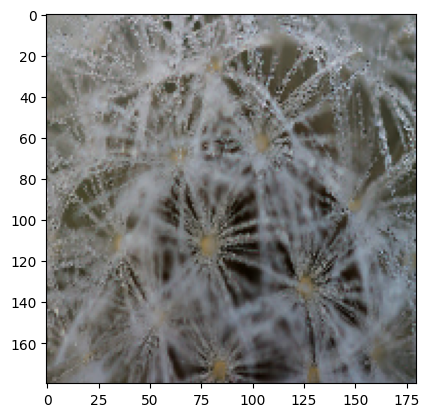

In [25]:
################# 참고 [필수 아님]
list(train_ds)[0][0] # 총 32개의 이미지
img=list(train_ds)[0][0][1].numpy().astype("uint8")
plt.imshow(img)


### ▶[Part3.] 모델 제작


In [26]:
# 성능을 높이도록 데이터세트 구성하기
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
## 증강 아래 내용외에 더 추가해도 됨  (아래의 사이트를 참조해서 다른 증강도 더 넣어도 되고, 또는 처음부터 이미지를 증강해서 준비해도 됨)
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [29]:
### 모델 제작

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),      #모델안에 스케일링 넣어주면 새로운 데이터 넣어서 추론할때 스케일링을 하지 않아도 됨
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='relu')
])

In [41]:
model.summary()

# 파라미터 계산법
# layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))
#   layers.Conv2D(16, 3, padding='same', activation='relu'),             ==> 3개의 input 채널임, 1개의 채널에는 3개의 커널사이즈가 있음. 즉 9개의 w값이 생성됨
#                                                                            1개채널당 9 * 3개채널 => 27개 + 바이어스1개 =>28개 --->  이런경우가 16개 있음 ===> 총 파람은 [28*16=448개]
#  layers.Conv2D(32, 3, padding='same', activation='relu'),              ==> 16개의 input 채널임, 1개의 채널당 9(커널사이즈가 가로3*세로3) 개의 w+1개 바이어스(10개) 
#                                                                            1개채널당 9* 16개채널 => 144개 + 바이어스1개 ==> 145개 --> 이런경우가 32개 있음 ==> 총 파람은 [145*32=4640]
# layers.Conv2D(64, 3, padding='same', activation='relu'),              ==> 32개의 input 채널임, 1개의 채널당 9 * 32개채널 + 바이어스 1 =>289개  * 64개 경우 ==> 총 파람은 [289*64=18496]
#   layers.Flatten()                                                    ==> 이미지사이즈 (22,22,64)를 모두 곱함.  30796
# layers.Dense(128, activation='relu'),                                 ==> 30976의 w + 1 개 b ===> 3977 * 128 = 3965056 파람
# layers.Dense(num_classes, activation='relu')                          ==> 128 의 w + 1개 b ==> 129*5=> 646개 파람

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


from tensorflow.keras.callbacks import ModelCheckpoint
modelpath="c:/data/model/iris/{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1) #verbose기본값이 0임, 1을 지정하지 않으면 결과가 화면에 출력되지 않음



epochs=10
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[checkpointer]
)

Epoch 1/10
91/92 [============================>.] - ETA: 0s - loss: 1.6839 - accuracy: 0.1715
Epoch 1: saving model to c:/data/model/iris\01-0.1757.hdf5
92/92 [==============================] - 9s 29ms/step - loss: 1.6830 - accuracy: 0.1720 - val_loss: 1.6094 - val_accuracy: 0.1757
Epoch 2/10
91/92 [============================>.] - ETA: 0s - loss: 1.6094 - accuracy: 0.1715
Epoch 2: saving model to c:/data/model/iris\02-0.1757.hdf5
92/92 [==============================] - 2s 22ms/step - loss: 1.6094 - accuracy: 0.1717 - val_loss: 1.6094 - val_accuracy: 0.1757
Epoch 3/10
91/92 [============================>.] - ETA: 0s - loss: 1.6094 - accuracy: 0.1718
Epoch 3: saving model to c:/data/model/iris\03-0.1757.hdf5
92/92 [==============================] - 2s 21ms/step - loss: 1.6094 - accuracy: 0.1717 - val_loss: 1.6094 - val_accuracy: 0.1757
Epoch 4/10
91/92 [============================>.] - ETA: 0s - loss: 1.6094 - accuracy: 0.1711
Epoch 4: saving model to c:/data/model/iris\04-0.1757.hdf

In [31]:
import pandas as pd
hist_df=pd.DataFrame(history.history)
hist_df.head()


,loss,accuracy,val_loss,val_accuracy
0,1.683040,0.172003,1.609438,0.175749
1,1.609437,0.171662,1.609438,0.175749
2,1.609437,0.171662,1.609438,0.175749
3,1.609437,0.171662,1.609438,0.175749
4,1.609437,0.171662,1.609438,0.175749


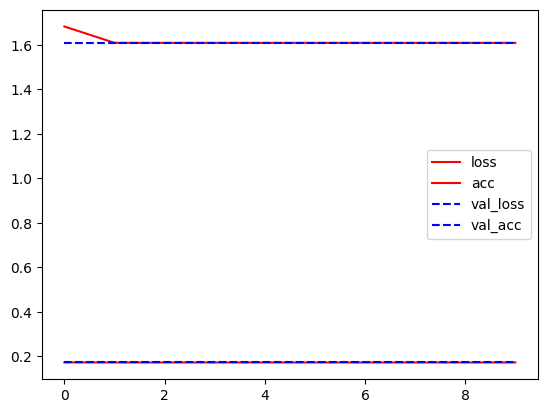

In [32]:
# y_vloss에 테스트셋(여기서는 검증셋)의 오차를 저장합니다.
y_vloss=hist_df['val_loss']

# y_loss에 학습셋의 오차를 저장합니다.
y_loss=hist_df['loss']

# x 값을 지정하고 테스트셋(검증셋)의 오차를 빨간색으로, 학습셋의 오차를 파란색으로 표시합니다.
plt.plot(hist_df['loss'],'r',label='loss')
plt.plot(hist_df['accuracy'],'r',label='acc')
plt.plot(hist_df['val_loss'],'--b',label='val_loss')
plt.plot(hist_df['val_accuracy'],'--b',label='val_acc')
plt.legend()


###  ▶[Part4.] 오차행렬표 검증표 제작

- 이 자료는 val_ds에서 배치단위로 데이터를 가져오기 때문에...

In [115]:
X_test,y_test=[],[]
for x, y in val_ds:
    if len(y)==32:
        X_test.append(x.numpy())
        y_test.append(y.numpy())


X_test=np.reshape(X_test, (-1,180,180,3))
y_test=np.reshape(y_test,(-1))

In [118]:
test_yhat=model.predict(X_test)
# 소프트맥스일때 y값이 원핫인코딩 되어 있다면 아래의 과정1,2가 필요함()
predict_y=np.argmax(test_yhat, axis=1) # [과정1]
real_y=y_test.copy()  # 원핫인코딩 되어 있지 않음으로    

22/22 [==============================] - 1s 33ms/step


In [121]:
# 오차행렬표임 (교재 388쪽의 하단내용)
import pandas as pd
from sklearn.metrics import confusion_matrix
conMatrix=confusion_matrix(real_y, predict_y)
conMatrix

array([[  0,  41,  20,  65,   0],
       [  0,  39,  32,  96,   2],
       [  0,  33,  13,  70,   0],
       [  0,  36,   1, 107,   0],
       [  0,  50,   5,  94,   0]], dtype=int64)

In [122]:
## 오차행렬 그래프를 그림으로 필수는 아님
pd.DataFrame(conMatrix)



,0,1,2,3,4
0,0,41,20,65,0
1,0,39,32,96,2
2,0,33,13,70,0
3,0,36,1,107,0
4,0,50,5,94,0


In [123]:

## 오차행렬 그래프를 그림으로 필수는 아님
# 오차행렬표를 데이터프레임으로 변환 (교재 388쪽 가장하단)
# 오차행렬표를 데이터프레임으로 작업하지 않고, 차트로 보여주는 모듈도 있음.
cnt=len(conMatrix)
pd.DataFrame(conMatrix, 
             index=['true_%d' % i for i in range(cnt)],
             columns=['pred_%d' % i for i in range(cnt)] )

,pred_0,pred_1,pred_2,pred_3,pred_4
true_0,0,41,20,65,0
true_1,0,39,32,96,2
true_2,0,33,13,70,0
true_3,0,36,1,107,0
true_4,0,50,5,94,0


Text(33.22222222222222, 0.5, 'true label')

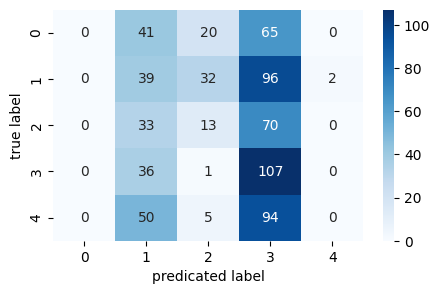

In [129]:
# 오차행렬표를 차트로 보여주는 작업_혼돈행렬
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(conMatrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

In [127]:
from sklearn.metrics import classification_report
print(classification_report(real_y, predict_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.20      0.23      0.21       169
           2       0.18      0.11      0.14       116
           3       0.25      0.74      0.37       144
           4       0.00      0.00      0.00       149

    accuracy                           0.23       704
   macro avg       0.13      0.22      0.14       704
weighted avg       0.13      0.23      0.15       704



c:\Users\user\miniconda3\envs\cpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\miniconda3\envs\cpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\miniconda3\envs\cpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###  ▶[Part5.]새로운 데이터로 추론

In [60]:
from PIL import Image
import numpy as np
img=Image.open('c:/data/a.jpg').resize((180,180)).convert('RGB')
img=np.array(img)

img=np.reshape(img, (1,180,180,3))
result=model.predict(img)
resultBun=np.argmax(result)
class_names[resultBun]

1/1 [==============================] - 0s 21ms/step


'dandelion'

 ▶[Part6.] 모델 저장

In [61]:
model.save('c:/data/flower.h5')